In [1]:
import numpy as np
import sklearn.linear_model as linear_model
from sklearn.model_selection import train_test_split
import sklearn.preprocessing as preprocessing
import matplotlib.pyplot as plt
import scipy

# 1 Polynomial Regression with SGD

In this exercise we will have a look again at overfitting and underfitting using the example of a polynomial regression.
However, we will find the optimal coefficient not by solving the linear problem as in Exercise 2, but by minimizing a loss function through Stochastic Gradient Descent.

The following function generates data from a polynomial of degree $d$ with given coefficients $\{c_k\}_{k=0}^{d}$ and noise level from a Gaussian of standard deviation $\xi$, namely $y_i = \sum_{k=0}^{d} c_k x_i^k + \xi \mathcal{N}(0, 1)$ where $x_i$ are uniformly distributed points. 

In [2]:
# This function generates data from a polynome, possibly with noise
def generate_polynome_data(polynome, noise_std, n, bound, seed):
    """
    arguments:
        - polynome  : list of coefficients representing the polynom (polynome[i] multiplies X^i)
        - noise_std : standard deviation of the gaussian noise
        - n         : number of data points
        - bound     : for points x the sampling inverval is +-bound
    returns:
        - (X, y)    : list of n points with y = poly(x) + gaussian noise
    """
    rs = np.random.RandomState(seed)
    degree = len(polynome) - 1
    samples = rs.uniform(-bound, bound, size=n)
    xs = np.copy(samples)
    samples = np.ones((n, degree + 1)).T * samples
    powers = np.power(samples.T, np.arange(0, degree + 1, 1))
    return xs.reshape(-1, 1), np.sum(powers * polynome, axis=1) + rs.normal(
        0, noise_std, size=n
    )

## 1.1 Generate data

Generate $n$ noisy data points (say $5 \leqslant n \leqslant 10$) from the polynomial $y_i = x_i^2  + 0.5 x_i^3$ with a given noise level.
These represent the training set.

In [3]:
# Create 100 noisy datapoints within the training interval [-3, 3]
n = 100
train_bound = 3
noise_std = 1.0
polynom = np.array([0, 0, 1, 0.5])  # function y = x^2 + 0.5 * x^3
X_train, y_train = generate_polynome_data(polynom, noise_std, n, train_bound, seed=42)

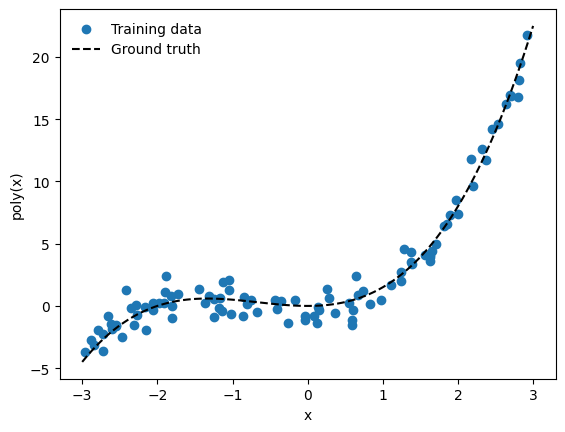

In [4]:
# Show the training data in a plot
x_plot = np.linspace(-train_bound, train_bound, 100).reshape((-1, 1))
y_plot = (
    polynom[0]
    + polynom[1] * x_plot
    + polynom[2] * x_plot**2
    + polynom[3] * x_plot**3
)
plt.scatter(X_train, y_train, label="Training data")
plt.plot(x_plot, y_plot, linestyle="--", color="black", label="Ground truth")
plt.legend(edgecolor="None")
plt.xlabel("x")
plt.ylabel("poly(x)");

We want to create some data for the test set too.

In [5]:
n_test = 40
X_test, y_test = generate_polynome_data(
    polynom, noise_std, n_test, train_bound, seed=43
)

## 1.2 Polynomials of different degrees
The loss function that we use for the training is the L2 metrics
$L(c) = \frac{1}{2n}\sum_{x_i \in X}(y_i-\hat{y_i})^2$, where $\hat{y_i}$ is the output of a polynomial on the input $x_i$ and $y_i$ is the ground-truth output. 


What are the gradients with respect to the coefficients $c$?

$\frac{\partial L(c)}{\partial c_k} = - \frac{1}{n}\sum_{x_i \in X} (y_i-\hat{y_i}) x_i^k$


We need to write the functions to compute the loss function and its gradient.

In [6]:
# Function that generates the feature matrix
def create_features(X, d):
    X_features = X**0

    for i in range(1, d + 1):
        X_features = np.concatenate(
            (X_features, X**i / scipy.special.factorial(i)), axis=-1
        )

    return X_features

In [7]:
# Function to predict the labels
def predict_label(X, c):
    y_pred = X @ c
    return y_pred

In [8]:
# Function to compute the loss
def loss(X, y, c, lambd):
    y_pred = predict_label(X, c)
    n = X.shape[0]
    return np.sum((y - y_pred) ** 2) / (2 * n) + lambd * np.mean(c**2, axis=-1)

In [9]:
# Fucntion to compute the gradient of the loss
def grad(X, y, c, lambd):
    y_pred = predict_label(X, c)
    n = X.shape[0]
    return -(X.T @ (y - y_pred)) / n + lambd * 2 * c / c.shape[0]

We now write a function that performs the training using the Stochastic Gradient Descent scheme

In [10]:
# Perform the SGD training
def sgd_training(
    X_train,
    y_train,
    X_test,
    y_test,
    d,
    BATCHSIZE=16,
    EPOCHS=1000,
    lr=0.001,
    lambd=1e-12,
):
    # create the features
    X_train_features = create_features(X_train, d)
    X_test_features = create_features(X_test, d)

    # set initial values for the parameters
    c = np.random.RandomState(seed=42).randn(X_train_features.shape[1])

    # lists to store the training and test errors
    MSE_test = []
    MSE_train = []

    # for several epochs (= runs over complete training data)
    for e in range(EPOCHS):
        # compute current errors on test and train
        MSE_train.append(np.mean((y_train - X_train_features @ c) ** 2))
        MSE_test.append(np.mean((y_test - X_test_features @ c) ** 2))

        # split the training set into batches and do a gradient step for each batch
        for b in range(
            0, ((X_train_features.shape[0] // BATCHSIZE) - 1) * BATCHSIZE, BATCHSIZE
        ):
            X_batch = X_train_features[b : b + BATCHSIZE]
            y_batch = y_train[b : b + BATCHSIZE]

            # run a gradient step on every batch
            c = c - lr * grad(X_batch, y_batch, c, lambd)

    return c, MSE_train, MSE_test

In [11]:
# degrees of polynomials
ds = [1, 2, 3, 5, 10, 50, 100, 150, 200]

cs = []
MSE_trains = []
MSE_tests = []

for d in ds:
    c, MSE_train, MSE_test = sgd_training(X_train, y_train, X_test, y_test, d)
    cs.append(c)
    MSE_trains.append(MSE_train)
    MSE_tests.append(MSE_test)

MSE_trains = np.array(MSE_trains)
MSE_tests = np.array(MSE_tests)

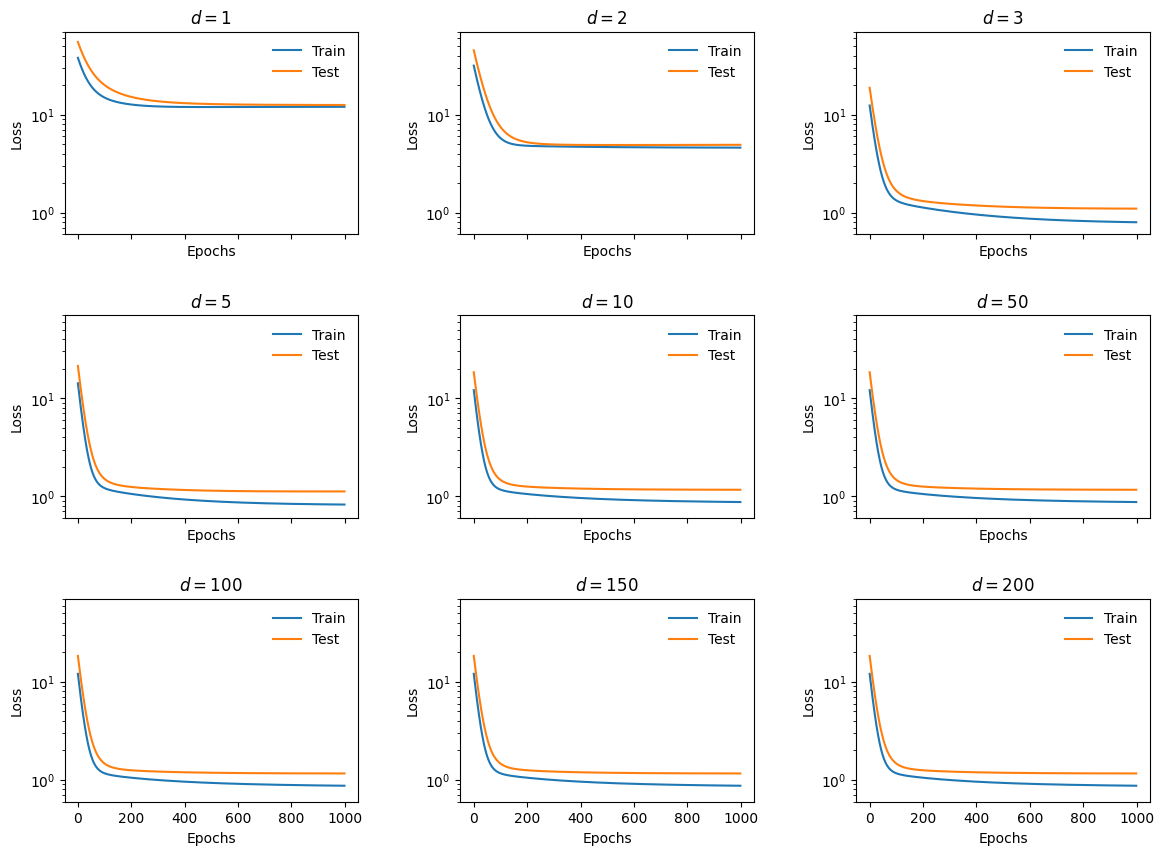

In [12]:
# Plotting the learning curves
fig, axes = plt.subplots(3, 3, figsize=(14, 10), sharex=True)
axes = axes.flatten()

for i in range(9):
    d = ds[i]
    ax = axes[i]

    ax.plot(MSE_trains[i], label="Train", color="tab:blue")
    ax.plot(MSE_tests[i], label="Test", color="tab:orange")

    ax.set_title(f"$d = {d}$")
    ax.set_yscale("log")
    ax.set_ylim(6e-1, 7e1)
    ax.set_ylabel("Loss")
    ax.set_xlabel("Epochs")
    ax.legend(edgecolor="None")

fig.subplots_adjust(hspace=0.4, wspace=0.35)

Let us compute the final test error as a function of the model complexity (degree of the polynomial). 
Show that you recover the well-known U-shaped curve of the bias-variance tradeoff.

Text(0, 0.5, 'Test loss')

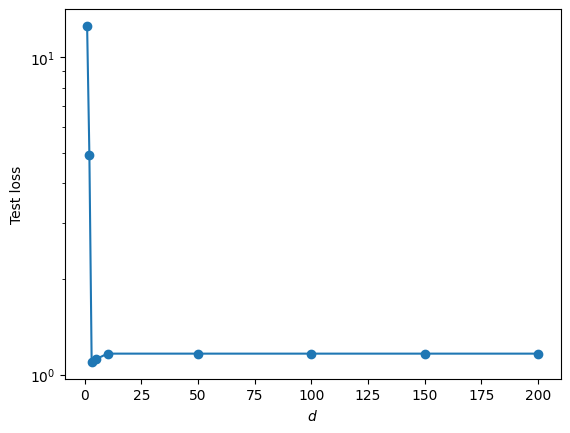

In [13]:
# Best MSE on the test set
MSE_test_last = np.mean(MSE_tests[:, -10:], axis=-1)

fig, ax = plt.subplots()

ax.plot(ds, MSE_test_last, marker="o")

ax.set_yscale("log")
ax.set_xlabel("$d$")
ax.set_ylabel("Test loss")

Let us plot the curves of the different polynomials

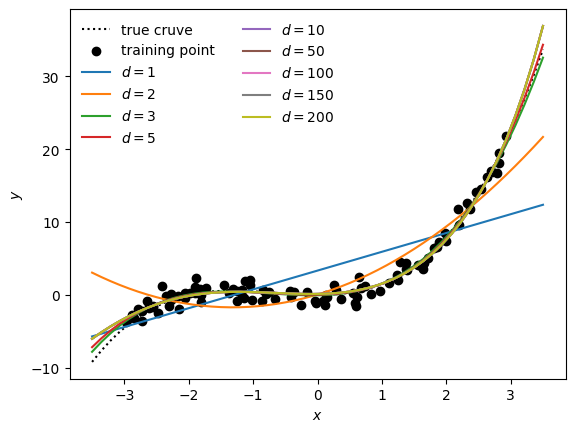

In [14]:
# Plotting the learned polynomials
plot_bound = 3.5
X_plot = np.linspace(-plot_bound, plot_bound, 50).reshape((-1, 1))

fig, ax = plt.subplots()

ax.plot(
    X_plot, X_plot**2 + 0.5 * X_plot**3, c="k", linestyle=":", label="true cruve"
)
ax.scatter(X_train, y_train, c="k", label="training point")

for i in range(len(ds)):
    X_plot_features = create_features(X_plot, ds[i])
    y_plot = predict_label(X_plot_features, cs[i])

    ax.plot(X_plot, y_plot, label=f"$d = {ds[i]}$")

ax.set_ylabel("$y$")
ax.set_xlabel("$x$")
ax.legend(edgecolor="None", ncols=2)

# 2:  SGD for Linear Regression on a health dataset

In this exercise we want to repeat how to load a real-world dataset.

Then, we want to implement SGD to infer the parameters and compare this with the LinearRegression classes results from sklearn.

In [1]:
# Import diabetes dataset from scikit-learn toy-dataset examples
from sklearn.datasets import load_diabetes

In [2]:
# Load boston dataset
diabetes = load_diabetes()

# Check what it contains
print(diabetes.DESCR)

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

:Number of Instances: 442

:Number of Attributes: First 10 columns are numeric predictive values

:Target: Column 11 is a quantitative measure of disease progression one year after baseline

:Attribute Information:
    - age     age in years
    - sex
    - bmi     body mass index
    - bp      average blood pressure
    - s1      tc, total serum cholesterol
    - s2      ldl, low-density lipoproteins
    - s3      hdl, high-density lipoproteins
    - s4      tch, total cholesterol / HDL
    - s5      ltg, possibly log of serum triglycerides level
    - s6      glu, blood sugar level

Note: Each of these 10 feature variables have bee

In [3]:
# Extract the dataset
X = diabetes.data
y = diabetes.target
# print the dimension of the X matrix and the y vector
print("the dimension of X is (n, d)=", X.shape, "the dimension of y is (n,)=", y.shape)

the dimension of X is (n, d)= (442, 10) the dimension of y is (n,)= (442,)


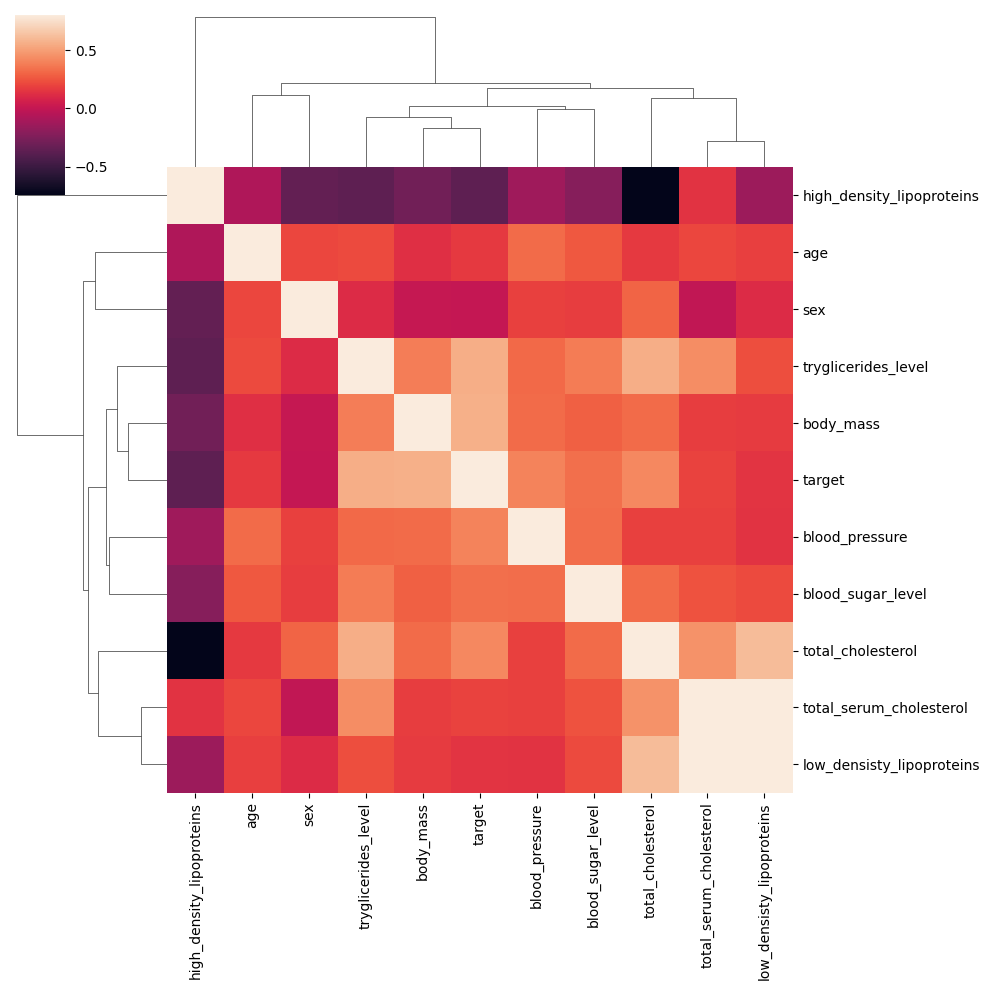

In [12]:
# visualization of the dataset
import pandas as pd
import seaborn as sns

df = pd.DataFrame(
    X,
    columns=[
        "age",
        "sex",
        "body_mass",
        "blood_pressure",
        "total_serum_cholesterol",
        "low_densisty_lipoproteins",
        "high_density_lipoproteins",
        "total_cholesterol",
        "tryglicerides_level",
        "blood_sugar_level",
    ],
)
df["target"] = y
corr_mat = df.corr()  # compute the correlation matrix of the features vectors
sns.clustermap(corr_mat, vmax=0.8);  # plot a clustered heatmap

## 2.1 Normalization
[Normalize](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.normalize.html) the input data using the L2 norm, as well as the target data by the maximum value.

In [7]:
X = preprocessing.normalize(X, norm="l2")
y = y / y.max()

In [8]:
# Split the data
X_train, X_validation, y_train, y_validation = train_test_split(
    X, y, test_size=0.2, random_state=14
)
X_train, X_test, y_train, y_test = train_test_split(
    X_train, y_train, test_size=0.3, random_state=14
)

## 2.2 Implementing gradients for Linear Regression

The model we consider is $\hat{y} = w x + c$.

We need to calculate the gradients for the training dataset $X$ of the loss
$L(w,c) = \frac{1}{2n}\sum_{x_i \in X}(y_i-\hat{y_i})^2 $

What are the gradients?

- $\frac{\partial L(w,c)}{\partial w} = -\frac{1}{n}\sum_{x_i \in X} (y_i-\hat{y_i})x_i $
- $\frac{\partial L(w,c)}{\partial c} = -\frac{1}{n}\sum_{x_i \in X} (y_i-\hat{y_i})$

Implement them below.

In [ ]:
def grad_w(X, y, w, c):
    # outputs parital L(w,c)/ partial w
    y_pred = w @ X.T + c
    return -1 / X.shape[0] * ((y - y_pred) @ X)

In [ ]:
def grad_c(X, y, w, c):
    # outputs parital L(w,c)/ partial c
    y_pred = w @ X.T + c
    return -1 / X.shape[0] * (y - y_pred).sum()

MSE test 0.02711821296837715


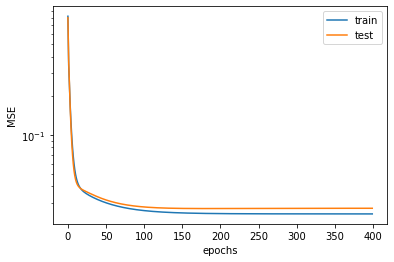

In [ ]:
# Set up stochasic batch gradient descent
BATCHSIZE = 16
EPOCHS = 400
lr = 0.15  # set the learning rate

# set initial values for the parameters
w = np.random.RandomState(seed=43).randn(X_train.shape[1])
c = 0


MSE_test = []
MSE_train = []

# for several epochs (= runs over complete training data)
for e in range(EPOCHS):
    # compute current errors on test and train
    MSE_train.append(((y_train - (w @ X_train.T + c)) ** 2).mean())
    MSE_test.append(((y_test - (w @ X_test.T + c)) ** 2).mean())

    # split the training set into batches
    for b in range(0, ((X_train.shape[0] // BATCHSIZE) - 1) * BATCHSIZE, BATCHSIZE):
        X_batch = X_train[b : b + BATCHSIZE]
        y_batch = y_train[b : b + BATCHSIZE]

        # run a gradient step on every batch
        w_ = w - lr * grad_w(X_batch, y_batch, w, c)
        c_ = c - lr * grad_c(X_batch, y_batch, w, c)

        w = w_
        c = c_

# plot the resulting learning curve
plt.plot(np.nan_to_num(MSE_train, nan=1000.0), label="train")
plt.plot(np.nan_to_num(MSE_test, nan=1000.0), label="test")
plt.xlabel("epochs")
plt.ylabel("MSE")
plt.legend()
plt.yscale("log")
print(f"SGD = MSE test {MSE_test[-1]}")

Text(0, 0.5, 'true test labels')

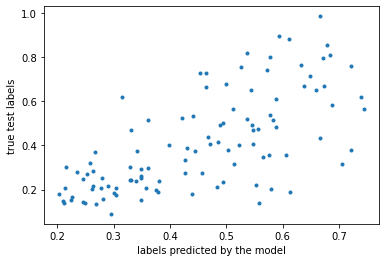

In [ ]:
# Show the predictions
plt.plot((w @ X_test.T + c), y_test, ".")
plt.xlabel("labels predicted by the model")
plt.ylabel("true test labels")

1. Explain in your own words what information the learning curve gives to you.

## 2.3 Loss Curve Quiz

What is wrong?
![L1](https://developers.google.com/static/machine-learning/testing-debugging/images/metric-curve-ex03.svg)   ![L2](https://developers.google.com/static/machine-learning/testing-debugging/images/metric-curve-ex02.svg)     ![L3](https://developers.google.com/static/machine-learning/testing-debugging/images/metric-curve-ex01.svg
)

*(From https://developers.google.com/machine-learning/testing-debugging/metrics/interpretic)*



## 2.4 Comparison with Library solution

sklearn = MSE test 0.026190964610037434


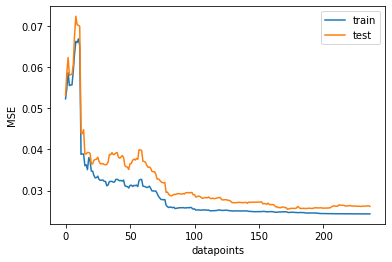

In [ ]:
MSE_train = []
MSE_test = []
for i in range(10, X_train.shape[0]):
    lm = linear_model.Ridge(alpha=0.01, fit_intercept=True).fit(
        X_train[:i], y_train[:i]
    )
    MSE_test.append(((y_test - lm.predict(X_test)) ** 2).mean())
    MSE_train.append(((y_train - lm.predict(X_train)) ** 2).mean())

plt.plot(MSE_train, label="train")
plt.plot(MSE_test, label="test")
plt.xlabel("datapoints")
plt.ylabel("MSE")
plt.legend()

print(f"sklearn = MSE test {MSE_test[-1]}")

Text(0, 0.5, 'true test labels')

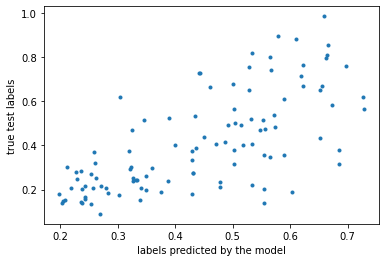

In [ ]:
plt.plot(lm.predict(X_test), y_test, ".")
plt.xlabel("labels predicted by the model")
plt.ylabel("true test labels")

1. Should you rather use the Library or your own implementation?

Answer:
- Own code:
  - Might be quick rather than downloading and installing.
  - Makes it explicit to you what is happening
  - Easy to make mistakes
  - Important learnings from doing things yourself
  - Easy to customize
- Libary:
  - Probably tested by many people, should work
  - Optimized for efficiency, nice software architecture…
  - Problems on the big libaries may occur, especially for experimental features [https://github.com/scikit-learn/scikit-learn/labels/Bug](https://github.com/scikit-learn/scikit-learn/labels/Bug)
  - Be careful of small taylormade libraries (e.g. few stars on github)


## 2.5 Validation data set
1. We did not use the validation data set so far, do we need it at all?
2. Are there hyperparamters for SGD?
3. How would can you estimate true the generalization error?

Answer:
- So far we did not play with hyperparameters
- SGD Hyperparameters
  - Learning Rate
  - Epochs
  - Stopping time
  - Initialization
  - ...
- After doing hyperparameter search, only by using the validation set